In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

from sklearn.datasets import load_breast_cancer
bcdat = load_breast_cancer()
X, y = bcdat.data, bcdat.target

random_state=14

In [ ]:
### Preprocessing ###

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#we create train and test data, then carve out validation data from train
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=random_state)

mm = MinMaxScaler() #Using this to transform data without distortions. Also, this does not assume data is normal, which standardscaler does.
X_train = mm.fit_transform(X_train) #fit_transform for train; only fit_transform train
X_valid = mm.transform(X_valid) #transform uses the parameters (e.g. mean, variance) learned by train
X_test = mm.transform(X_test) #transform uses the parameters (e.g. mean, variance) learned by train

In [ ]:
### Part 1a: PCA to get only five principal components ###

In [ ]:
pca5 = PCA(n_components = 5) #Number of PCs we want = 5
X_train_pca = pca5.fit_transform(X_train) #Fit it to model
X_test_pca = pca5.transform(X_test) #Transform (do not fit) the X_test (to do predictions later)
X_valid_pca = pca5.transform(X_valid)

variance_explained = np.sum(pca5.explained_variance_ratio_)
variance_explained #0.999

0.8541446051615719

In [ ]:
### Part 1b: Do prediction on these five components only. I will use a simple random forest ###

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

RF = RandomForestClassifier(max_depth=2, random_state=random_state)
RF.fit(X_train_pca,y_train)

y_pred_RF = RF.predict(X_test_pca)
for_rmse = np.sqrt(mean_squared_error(y_test, y_pred_RF))
print(for_rmse) #0.2294

0.22941573387056177


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(RF, X_train_pca, y_train, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)
print(rmse_scores.mean()) #0.2464

0.27972711286174123


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred_RF)
print(cm)

[[36  5]
 [ 1 72]]


In [ ]:
### Part 2: Fit Neural Network to predict "Malignant" (0) or "Benign" (1)

In [ ]:
import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()

In [ ]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train_pca.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="relu")(hidden2) #adding this layer 
concat = keras.layers.concatenate([input_, hidden3])
output = keras.layers.Dense(1)(concat) 
model = keras.models.Model(inputs=[input_], outputs=[output])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 40)           240         ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 20)           820         ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 10)           210         ['dense_1[0][0]']                
                                                                                              

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history = model.fit(X_train_pca, y_train, epochs=30,validation_data=(X_valid_pca, y_valid))

Epoch 1/30
11/11 [==============================] - 1s 44ms/step - loss: 3.9009 - accuracy: 0.6364 - val_loss: 2.6437 - val_accuracy: 0.7193
Epoch 2/30
11/11 [==============================] - 0s 6ms/step - loss: 3.2426 - accuracy: 0.6686 - val_loss: 2.5875 - val_accuracy: 0.7544
Epoch 3/30
11/11 [==============================] - 0s 7ms/step - loss: 2.9469 - accuracy: 0.7038 - val_loss: 2.3532 - val_accuracy: 0.7807
Epoch 4/30
11/11 [==============================] - 0s 6ms/step - loss: 1.4825 - accuracy: 0.8416 - val_loss: 0.8906 - val_accuracy: 0.9035
Epoch 5/30
11/11 [==============================] - 0s 5ms/step - loss: 0.6118 - accuracy: 0.9208 - val_loss: 0.7883 - val_accuracy: 0.9035
Epoch 6/30
11/11 [==============================] - 0s 5ms/step - loss: 0.5894 - accuracy: 0.9208 - val_loss: 0.7822 - val_accuracy: 0.9035
Epoch 7/30
11/11 [==============================] - 0s 7ms/step - loss: 0.5853 - accuracy: 0.9208 - val_loss: 0.6773 - val_accuracy: 0.9123
Epoch 8/30
11/11 [=

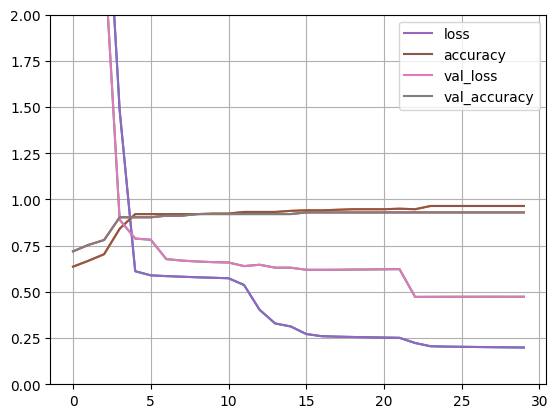

In [ ]:
metrics = pd.DataFrame(history.history)
plt.plot(metrics)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
mse_test = model.evaluate(X_test_pca, y_test)
y_pred_NN = model.predict(X_test_pca)

threshold = 0.5 #decision boundary on what to classify as 1 or 0. Potential weakness: unbalanced datasets.
y_pred_NN =  np.concatenate(np.where(y_pred_NN > threshold, 1, 0)).ravel() #makes it look similar to y_pred_RF
y_pred_NN[1:20]

4/4 [==============================] - 0s 3ms/step


array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
### Testing: No PCA ###

In [ ]:
#Wide and Deep Neural Network Model

#Run input through two hidden layers
#then, combine input from two hidden layers with "fresh" input i.e. using input data twice
#concatenate the two data together for output

input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(40, activation="relu")(input_)
hidden2 = keras.layers.Dense(20, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(10, activation="relu")(hidden2)
concat = keras.layers.concatenate([input_, hidden3])
output = keras.layers.Dense(1)(concat) 
model_noPCA = keras.models.Model(inputs=[input_], outputs=[output])

model_noPCA.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 30)]         0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 40)           1240        ['input_2[0][0]']                
                                                                                                  
 dense_5 (Dense)                (None, 20)           820         ['dense_4[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 10)           210         ['dense_5[0][0]']                
                                                                                            

In [ ]:
model_noPCA.compile(loss="binary_crossentropy", 
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"]) 
history_noPCA = model_noPCA.fit(X_train, y_train, epochs=30,validation_data=(X_valid, y_valid))

Epoch 1/30
11/11 [==============================] - 1s 24ms/step - loss: 5.5743 - accuracy: 0.5249 - val_loss: 2.5401 - val_accuracy: 0.7368
Epoch 2/30
11/11 [==============================] - 0s 5ms/step - loss: 1.3138 - accuracy: 0.7713 - val_loss: 1.5615 - val_accuracy: 0.8158
Epoch 3/30
11/11 [==============================] - 0s 5ms/step - loss: 0.9458 - accuracy: 0.8504 - val_loss: 1.4160 - val_accuracy: 0.8158
Epoch 4/30
11/11 [==============================] - 0s 5ms/step - loss: 0.8736 - accuracy: 0.8710 - val_loss: 1.3720 - val_accuracy: 0.8246
Epoch 5/30
11/11 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.8915 - val_loss: 1.2377 - val_accuracy: 0.8596
Epoch 6/30
11/11 [==============================] - 0s 6ms/step - loss: 0.6182 - accuracy: 0.9091 - val_loss: 1.2207 - val_accuracy: 0.8596
Epoch 7/30
11/11 [==============================] - 0s 5ms/step - loss: 0.4911 - accuracy: 0.9150 - val_loss: 1.0886 - val_accuracy: 0.8596
Epoch 8/30
11/11 [=

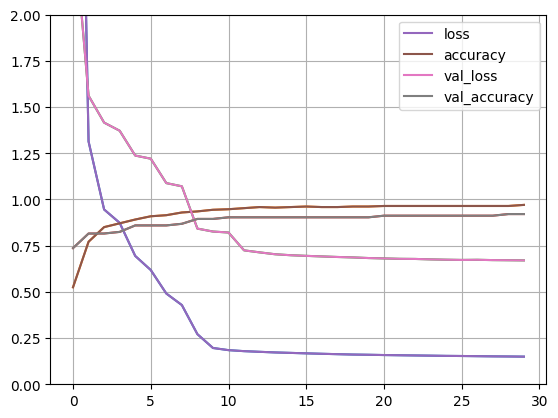

In [ ]:
metrics_noPCA = pd.DataFrame(history_noPCA.history)
plt.plot(metrics_noPCA)
for col in ('loss', 'accuracy','val_loss','val_accuracy'):
    metrics_noPCA[col].plot(legend=True)
plt.grid(True)
plt.gca().set_ylim(0, 2)
plt.show()

In [ ]:
y_pred_noPCA = model_noPCA.predict(X_test)

threshold = 0.5 #decision boundary on what to classify as 1 or 0. Potential weakness: unbalanced datasets.
y_pred_noPCA =  np.concatenate(np.where(y_pred_noPCA > threshold, 1, 0)).ravel() #makes it look similar to y_pred_RF
y_pred_noPCA[1:20]

4/4 [==============================] - 0s 2ms/step


array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [ ]:
### Saving ###
# save model in HDF5 format: architecture and hyperparameters, optimizer, starting state
model.save("my_keras_model.h5")

# load model
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
### Using early stopping and/or checkpoints ###

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True) # Save only best checkpoint, overwriting previous best model

history = model.fit(X_train_pca, y_train, epochs=10,
                    validation_data=(X_valid_pca, y_valid),
                    callbacks=[checkpoint_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test_pca, y_test)

Epoch 1/10
11/11 [==============================] - 1s 29ms/step - loss: 4.6618 - val_loss: 3.2895
Epoch 2/10
11/11 [==============================] - 0s 9ms/step - loss: 2.6079 - val_loss: 1.9439
Epoch 3/10
11/11 [==============================] - 0s 9ms/step - loss: 1.5592 - val_loss: 1.2385
Epoch 4/10
11/11 [==============================] - 0s 11ms/step - loss: 1.0296 - val_loss: 0.8569
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.7399 - val_loss: 0.6269
Epoch 6/10
11/11 [==============================] - 0s 9ms/step - loss: 0.5702 - val_loss: 0.5003
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.4738 - val_loss: 0.4178
Epoch 8/10
11/11 [==============================] - 0s 8ms/step - loss: 0.4106 - val_loss: 0.3626
Epoch 9/10
11/11 [==============================] - 0s 8ms/step - loss: 0.3629 - val_loss: 0.3218
Epoch 10/10
4/4 [==============================] - 0s 4ms/step - loss: 0.4024


In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(X_train_pca, y_train, epochs=50,
                    validation_data=(X_valid_pca, y_valid),
                    callbacks=[checkpoint_cb,early_stopping_cb])

model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test_pca, y_test)

#This will stop learning after 11 epochs

Epoch 1/50
11/11 [==============================] - 1s 20ms/step - loss: 0.2981 - val_loss: 0.2646
Epoch 2/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2734 - val_loss: 0.2448
Epoch 3/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2530 - val_loss: 0.2278
Epoch 4/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2350 - val_loss: 0.2128
Epoch 5/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2184 - val_loss: 0.1993
Epoch 6/50
11/11 [==============================] - 0s 8ms/step - loss: 0.2036 - val_loss: 0.1877
Epoch 7/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1910 - val_loss: 0.1776
Epoch 8/50
11/11 [==============================] - 0s 6ms/step - loss: 0.1793 - val_loss: 0.1689
Epoch 9/50
11/11 [==============================] - 0s 7ms/step - loss: 0.1691 - val_loss: 0.1609
Epoch 10/50
11/11 [==============================] - 0s 8ms/step - loss: 0.1597 - val_loss: 0.1535
Epoch 11/50
11/11 

In [ ]:
keras.backend.clear_session()